# HW 4.Сравнение автоэнкодеров и ResNet репрезентаций

В этом задании, вам предлагается сравнить эмбеддинги картинок, принадлежащих различным классам из CIFAR-10. Для сравнения, предлагается рассмотреть эмбеддинги, полученные из обученного классификатора, и эмбеддинги из автоэнкодера.

Вам нужно реализовать следующие функции:
- Извлечение эмбеддингов из предобученного классификатора;
- Снижение размерности эмбеддингов с помощью PCA;
- Обучение автоэнкодера и извлечение его признаков;
- Написание функции визуализации

# 1. Загрузка CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor and scale to [0,1]
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


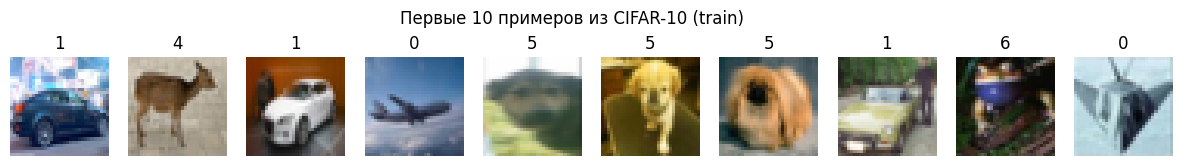

In [2]:
# Получим первую партию изображений и меток
images, labels = next(iter(train_loader))

# Отобразим первые 10 изображений
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img = images[i].permute(1, 2, 0).numpy()  # Переводим из (C, H, W) -> (H, W, C)
    axes[i].imshow(img)
    axes[i].set_title(f"{labels[i].item()}")
    axes[i].axis("off")

plt.suptitle("Первые 10 примеров из CIFAR-10 (train)")
plt.show()

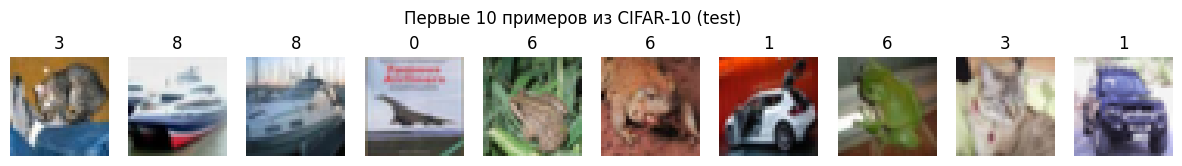

In [3]:
# Получим первую партию изображений и меток
images, labels = next(iter(test_loader))

# Отобразим первые 10 изображений
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img = images[i].permute(1, 2, 0).numpy()  # Переводим из (C, H, W) -> (H, W, C)
    axes[i].imshow(img)
    axes[i].set_title(f"{labels[i].item()}")
    axes[i].axis("off")

plt.suptitle("Первые 10 примеров из CIFAR-10 (test)")
plt.show()

# 2. Загрузка предобученной модели

В данной задаче от вас не требуется обучать новую модель. Мы воспользуемся предобученной модели ResNet18 на ImageNet. Под эмбеддингом будем понимать вектор, полученный до последнего слоя классификации.

In [4]:
from torchvision.models import resnet18, ResNet18_Weights

# Загрузите веса модели
classificator = resnet18(weights=ResNet18_Weights.DEFAULT)

# Сохраняем размерность эмбеддингов (до последнего слоя)
embedding_size = classificator.fc.in_features  # 512 для ResNet18

classificator.fc = nn.Linear(embedding_size, 10)

# Заморозим веса, тк мы не хотим тренировать их
for param in classificator.parameters():
    param.requires_grad = False

# Переводим в режим оценки и на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classificator = classificator.to(device)
classificator.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
import numpy as np

# Визуализируем 100 картинок
max_steps = 10
# Сохраненные эмбеддинги
embeddings = []
# Сохраняем классы эмбеддингов
classes = []

# Функция-хук для захвата выхода перед последним полносвязным слоем

def hook_fn(module, input, output):
  # avgpool output: shape [batch_size, 512, 1, 1]
  # превращаем в [batch_size, 512]
  embeddings.append(output.view(output.size(0), -1).detach().cpu())

# Регистрируем хук
hook = classificator.avgpool.register_forward_hook(hook_fn)

# Визуализируем 100 картинок (max_steps = 10 по 10 картинок)
max_steps = 10
step = 0

with torch.no_grad():
    for images, labels in test_loader:
        if step >= max_steps:
            break
        images = images.to(next(classificator.parameters()).device)
        classificator(images)  # вызовет hook_fn
        classes.extend(labels.cpu().tolist())
        step += 1

# Отвяжем хук после использования
hook.remove()

# Объединяем эмбеддинги в один массив
embeddings = torch.cat(embeddings, dim=0).numpy()
classes = np.array(classes)

In [6]:
embeddings

array([[0.61085093, 0.        , 0.37346268, ..., 2.764346  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.3389628 , 0.8748554 ,
        0.        ],
       [0.3025396 , 0.01957411, 0.        , ..., 2.589553  , 0.2021878 ,
        0.        ],
       ...,
       [0.04015139, 0.        , 0.        , ..., 0.        , 0.47892666,
        0.        ],
       [0.06184939, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50231326, 0.        , 0.        , ..., 0.9006854 , 0.40210503,
        0.        ]], dtype=float32)

In [7]:
classes

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2,
       1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
       8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7])

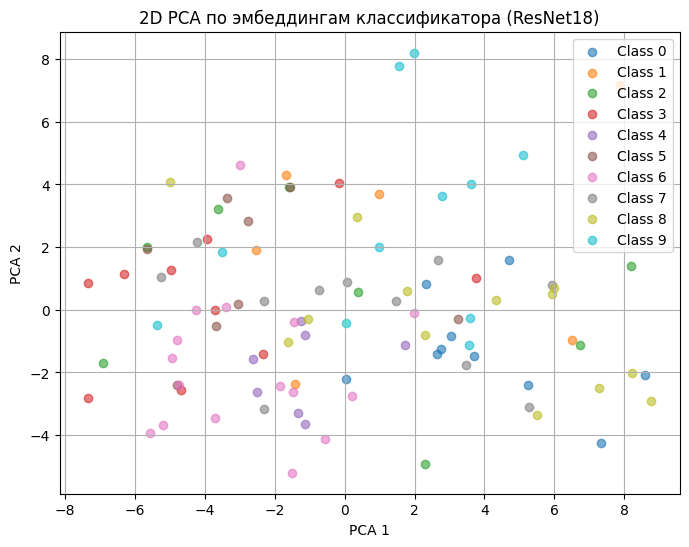

In [8]:
from sklearn.decomposition import PCA

# Передайте эмбеддинги в PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings) #embeddings = (N, D), станет (N, 2)

# Визуализируем эмбеддинги, с учетом их классов
def visualization_of_embeddings(pca_result, labels_array):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        idxs = classes == i
        plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=f"Class {i}", alpha=0.6)
    plt.legend()
    plt.title("2D PCA по эмбеддингам классификатора (ResNet18)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

visualization_of_embeddings(pca_result, classes)

# 3. Обучение автоэнкодера

В данной реализации приведен не очень хороший, но рабочий автоэнкодер. Его уже придется обучить на тренировочном датасете

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=768,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=latent_dim),
            nn.LeakyReLU(0.1)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(in_features=latent_dim,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=768),
            nn.LeakyReLU(0.1)
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = torch.flatten(encoded, 1)
        encoded = self.linear1(encoded)

        decoded = self.linear2(encoded)
        decoded = decoded.reshape(-1,48,4,4)
        decoded = self.decoder(decoded)
        return decoded

    def encode(self, x):
      encoded = self.encoder(x)

      encoded = torch.flatten(encoded, 1)
      encoded = self.linear1(encoded)
      return encoded

In [12]:
latent_dim = 2
autoencoder = Autoencoder(latent_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)


In [13]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6378
Epoch [2/10], Loss: 0.6350
Epoch [3/10], Loss: 0.6044
Epoch [4/10], Loss: 0.6307
Epoch [5/10], Loss: 0.6116
Epoch [6/10], Loss: 0.6553
Epoch [7/10], Loss: 0.6190
Epoch [8/10], Loss: 0.6012
Epoch [9/10], Loss: 0.6427
Epoch [10/10], Loss: 0.5921


In [14]:
autoencoder.eval()

# Визуализируем 100 картинок
max_steps = 10
# Сохраненные эмбеддинги
embeddings_ae = []
# Сохраняем классы эмбеддингов
classes_ae = []

for i, (images, labels) in enumerate(test_loader):
  if i >= max_steps:
    break
  images = images.to(device)
  # Получаем 2D-эмбеддинги напрямую из энкодера
  encoded = autoencoder.encode(images)
  embeddings_ae.append(encoded.detach().cpu())
  classes_ae.extend(labels.numpy())

# Объединяем тензоры в один
embeddings_ae_tensor = torch.cat(embeddings_ae,  dim=0).numpy()
classes_ae_array = np.array(classes_ae)

In [15]:
embeddings_ae_tensor

array([[ 1.3016098e+00,  8.4003836e-01],
       [ 1.5878132e-01,  1.7204621e-01],
       [ 4.5126590e-01,  2.9949823e-01],
       [ 3.8560921e-01,  3.5505536e-01],
       [ 1.6127189e+00,  1.6697563e+00],
       [ 1.4090757e+00,  6.8895751e-01],
       [ 1.9818783e+00,  9.8930156e-01],
       [ 1.5995364e+00,  7.1111584e-01],
       [ 9.4760960e-01,  2.2061090e+00],
       [ 3.2987761e-01,  5.1570261e-01],
       [ 9.3275738e-01,  1.5532017e+00],
       [ 5.2629220e-01,  3.3037090e-01],
       [ 1.8380147e+00,  9.9946666e-01],
       [ 2.1720767e+00,  1.0055208e+00],
       [ 9.3062931e-01,  5.9163451e-01],
       [ 8.3914167e-01,  5.5631858e-01],
       [ 1.3922350e+00,  1.7083269e+00],
       [ 1.1230509e+00,  1.8652030e+00],
       [ 4.2336091e-02, -1.5395079e-03],
       [ 1.5429676e+00,  1.0640705e+00],
       [ 9.2026454e-01,  9.0561008e-01],
       [ 2.3726001e-01,  3.7268145e+00],
       [ 1.5621251e+00,  7.3728633e-01],
       [ 1.3207908e+00,  1.2798110e+00],
       [ 7.07390

In [16]:
classes_ae_array

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2,
       1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
       8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7])

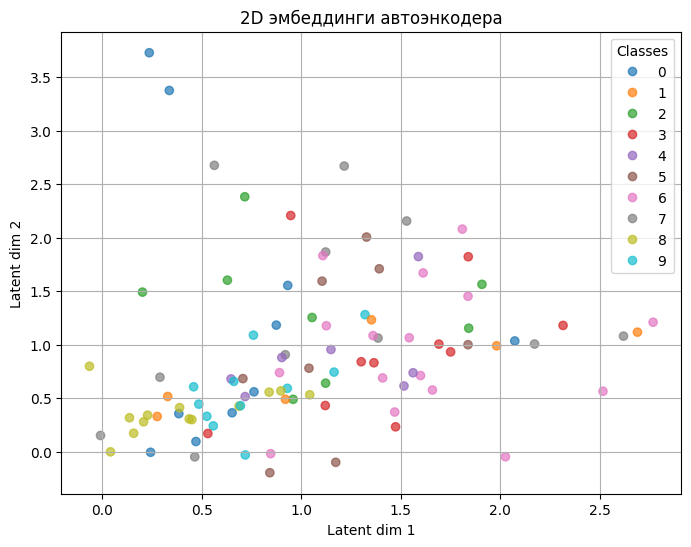

In [17]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_ae_tensor[:, 0],
    embeddings_ae_tensor[:, 1],
    c=classes_ae_array,
    cmap='tab10',
    alpha=0.7
)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("2D эмбеддинги автоэнкодера")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.grid(True)
plt.show()

## Сравнение двух графиков

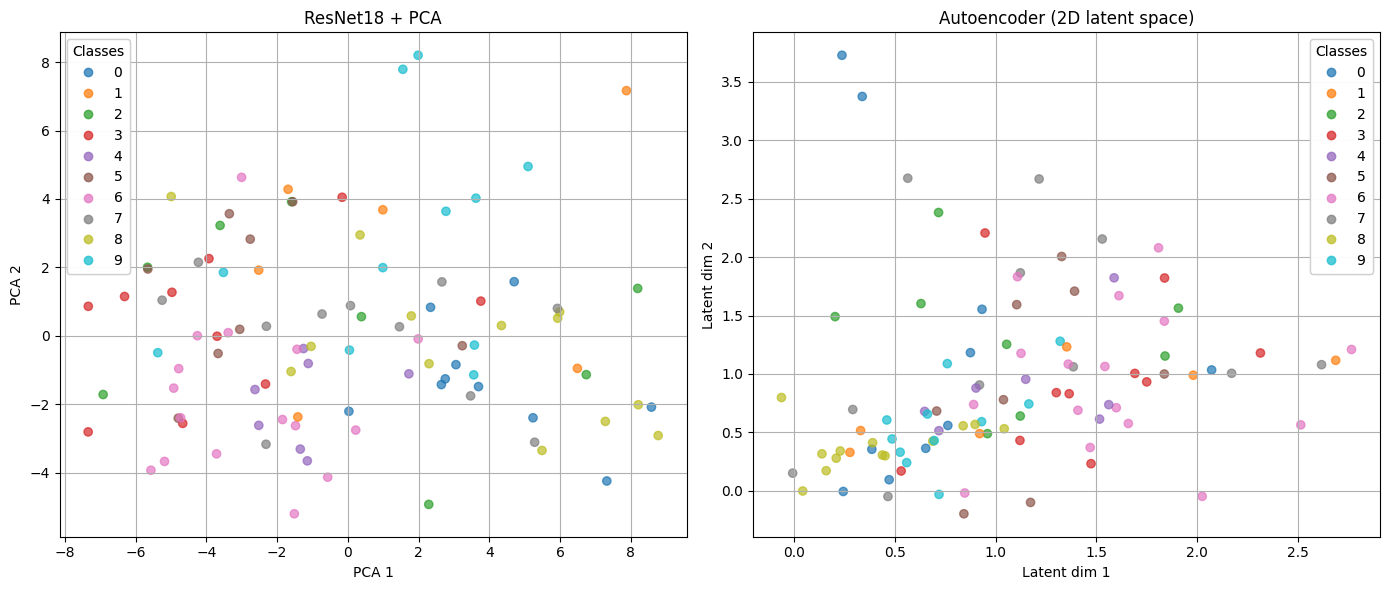

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ЛЕВЫЙ ГРАФИК — ResNet18 + PCA
scatter1 = axs[0].scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=classes, cmap='tab10', alpha=0.7
)
axs[0].set_title("ResNet18 + PCA")
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")
axs[0].grid(True)
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Classes")
axs[0].add_artist(legend1)

# ПРАВЫЙ ГРАФИК — Autoencoder (latent dim = 2)
scatter2 = axs[1].scatter(
    embeddings_ae_tensor[:, 0], embeddings_ae_tensor[:, 1],
    c=classes_ae_array, cmap='tab10', alpha=0.7
)
axs[1].set_title("Autoencoder (2D latent space)")
axs[1].set_xlabel("Latent dim 1")
axs[1].set_ylabel("Latent dim 2")
axs[1].grid(True)
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)

plt.tight_layout()
plt.show()

С помощью графиков мы можем визуально сравнить, насколько хорошо каждая модель разделяет классы. Видим, что есть определенные скопления некоторых групп классов, но четко разделимых границ практически не наблюдается.

## Эксперимент. UMAP и t-SNE

t-SNE и UMAP часто дают более выразительную визуализацию, чем PCA, особенно при сложной нелинейной структуре данных.

### UMAP и t-SNE для Resnet18

In [20]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

# t-SNE по эмбеддингам классификатора
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings)

# UMAP по эмбеддингам классификатора
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


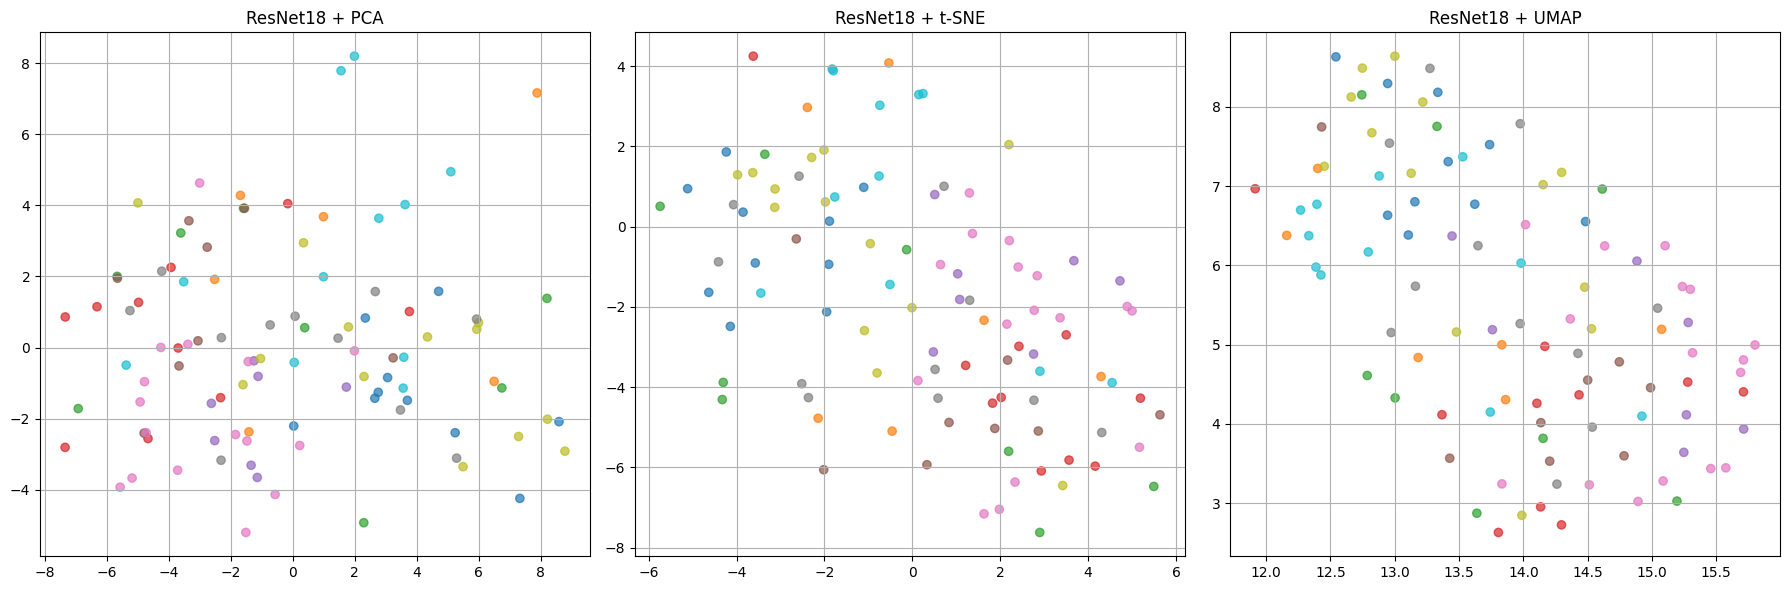

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# PCA
axs[0].scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=classes, cmap='tab10', alpha=0.7
)
axs[0].set_title("ResNet18 + PCA")
axs[0].grid(True)

# t-SNE
axs[1].scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1],
    c=classes, cmap='tab10', alpha=0.7
)
axs[1].set_title("ResNet18 + t-SNE")
axs[1].grid(True)

# UMAP
axs[2].scatter(
    embeddings_umap[:, 0], embeddings_umap[:, 1],
    c=classes, cmap='tab10', alpha=0.7
)
axs[2].set_title("ResNet18 + UMAP")
axs[2].grid(True)

plt.tight_layout()
plt.show()

### UMAP и t-SNE для автоэнкодера

In [23]:
# t-SNE по эмбеддингам автоэнкодера
tsne_ae = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_ae_tsne = tsne_ae.fit_transform(embeddings_ae_tensor)

# UMAP по эмбеддингам автоэнкодера
umap_model_ae = umap.UMAP(n_components=2, random_state=42)
embeddings_ae_umap = umap_model_ae.fit_transform(embeddings_ae_tensor)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


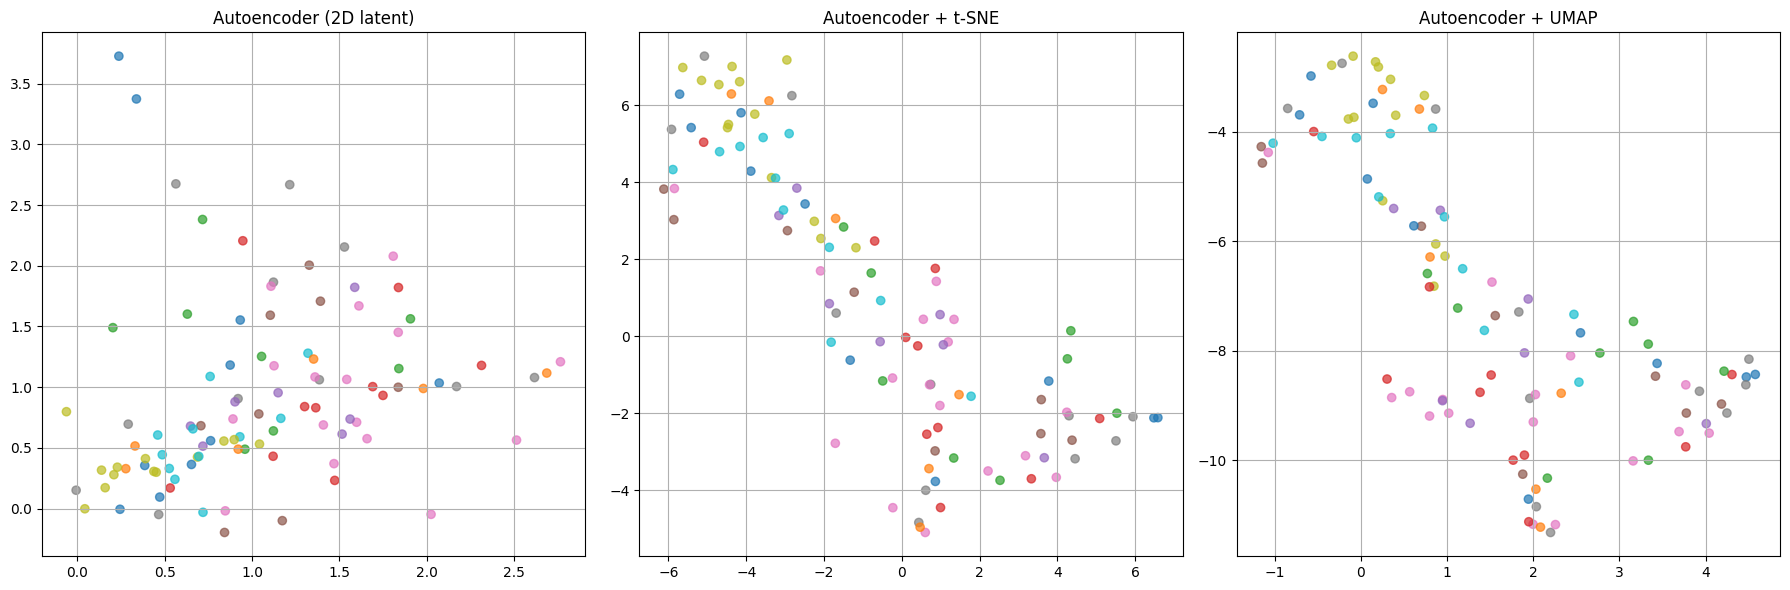

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Raw 2D latent space
axs[0].scatter(
    embeddings_ae_tensor[:, 0], embeddings_ae_tensor[:, 1],
    c=classes_ae_array, cmap='tab10', alpha=0.7
)
axs[0].set_title("Autoencoder (2D latent)")
axs[0].grid(True)

# t-SNE
axs[1].scatter(
    embeddings_ae_tsne[:, 0], embeddings_ae_tsne[:, 1],
    c=classes_ae_array, cmap='tab10', alpha=0.7
)
axs[1].set_title("Autoencoder + t-SNE")
axs[1].grid(True)

# UMAP
axs[2].scatter(
    embeddings_ae_umap[:, 0], embeddings_ae_umap[:, 1],
    c=classes_ae_array, cmap='tab10', alpha=0.7
)
axs[2].set_title("Autoencoder + UMAP")
axs[2].grid(True)

plt.tight_layout()
plt.show()

UMAP и t-SNE не сильно помогли визуализировать разделение на классы.